# 1) Preparación previa

#### Carga de librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# ES MUY PROBABLE QUE SE NECESITE INSTALAR PMDARIMA, A CONTINUACIÓN SE DEJA EL PIP INSTALL:
# !pip install pmdarima
# from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

#### Lectura del dataset

In [2]:
df = pd.read_csv('coin_Bitcoin.csv', delimiter=',')

Se realizan las modificaciones del dataset pertinentes para el análisis de series de tiempo

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.PeriodIndex(df.Date, freq='D')
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,,
2013-04-29,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02,4,Bitcoin,BTC,2013-05-02,125.599999,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


#### Dummies

In [4]:
df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)

df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timeIndex
Date,,,,,,,,,,,
2013-04-29,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,0
2013-04-30,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,1
2013-05-01,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,2
2013-05-02,4,Bitcoin,BTC,2013-05-02,125.599999,92.281898,116.379997,105.209999,0.0,1.168517e+09,3
2013-05-03,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,4


In [5]:
df.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,timeIndex
Date,,,,,,,,,,,
2021-02-23,2858,Bitcoin,BTC,2021-02-23,54204.92976,45290.59027,54204.92976,48824.42687,1.061020e+11,9.099260e+11,2857
2021-02-24,2859,Bitcoin,BTC,2021-02-24,51290.13669,47213.49816,48835.08766,49705.33332,6.369552e+10,9.263930e+11,2858
2021-02-25,2860,Bitcoin,BTC,2021-02-25,51948.96698,47093.85302,49709.08242,47093.85302,5.450657e+10,8.777660e+11,2859
2021-02-26,2861,Bitcoin,BTC,2021-02-26,48370.78526,44454.84211,47180.46405,46339.76008,3.509680e+11,8.637520e+11,2860
2021-02-27,2862,Bitcoin,BTC,2021-02-27,48253.27010,45269.02577,46344.77224,46188.45128,4.591095e+10,8.609780e+11,2861


Se agregan las columnas necesarias

In [6]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

Se crean las dummies

In [7]:
dummies_mes = pd.get_dummies(df['Month'], drop_first=True, prefix='Month')
df = df.join(dummies_mes)
df.sample(10)

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-20,2274,Bitcoin,BTC,2019-07-20,11048.662350,10451.276010,10525.819000,10767.139520,2.020662e+10,1.919640e+11,...,0,0,0,0,1,0,0,0,0,0
2015-11-20,936,Bitcoin,BTC,2015-11-20,326.472992,312.217011,326.411011,322.022003,5.315290e+07,4.786302e+09,...,0,0,0,0,0,0,0,0,1,0
2017-09-04,1590,Bitcoin,BTC,2017-09-04,4591.629883,4108.399902,4591.629883,4236.310059,2.987330e+09,7.008710e+10,...,0,0,0,0,0,0,1,0,0,0
2014-08-11,470,Bitcoin,BTC,2014-08-11,591.507019,574.051025,591.281982,576.367981,1.476420e+07,7.567179e+09,...,0,0,0,0,0,1,0,0,0,0
2020-12-05,2778,Bitcoin,BTC,2020-12-05,19160.449260,18590.193680,18698.385280,19154.231130,2.724246e+10,3.555640e+11,...,0,0,0,0,0,0,0,0,0,1
2018-07-16,1905,Bitcoin,BTC,2018-07-16,6741.750000,6357.009766,6357.009766,6741.750000,4.725800e+09,1.156380e+11,...,0,0,0,0,1,0,0,0,0,0
2015-12-28,974,Bitcoin,BTC,2015-12-28,429.769012,418.480988,423.342987,422.278992,4.963860e+07,6.341733e+09,...,0,0,0,0,0,0,0,0,0,1
2015-08-01,825,Bitcoin,BTC,2015-08-01,284.932007,278.112000,284.686005,281.601013,1.899500e+07,4.069120e+09,...,0,0,0,0,0,1,0,0,0,0
2020-01-23,2461,Bitcoin,BTC,2020-01-23,8687.747088,8333.637874,8680.650560,8406.516068,2.577068e+10,1.528130e+11,...,0,0,0,0,0,0,0,0,0,0


#### Se divide el dataset en Train y Test, usando rangos personalizados

In [8]:
# Se utiliza este método para manejar el shape que se aplicará a los demás modelos
end_date = '2021-01-27'
mask1 = (df['Date'] <= end_date)
mask2 = (df['Date'] > end_date)

In [9]:
# Se pasan las máscaras para obtener train y test:
df_train = df.loc[mask1]
df_test = df.loc[mask2]
print("train shape",df_train.shape)
print("test shape",df_test.shape)

train shape (2831, 24)
test shape (31, 24)


#### Chequeo de que la primer fecha de test sea la siguiente al final de train:

In [10]:
df_train.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-23,2827,Bitcoin,BTC,2021-01-23,33360.97819,31493.15967,32985.75691,32067.64288,4.835474e+10,5.967330e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-24,2828,Bitcoin,BTC,2021-01-24,32944.00894,31106.68577,32064.37632,32289.37809,4.864383e+10,6.008890e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-25,2829,Bitcoin,BTC,2021-01-25,34802.74298,32087.78797,32285.79891,32366.39305,5.989705e+10,6.023500e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-26,2830,Bitcoin,BTC,2021-01-26,32794.54959,31030.26597,32358.61317,32569.84956,6.025542e+10,6.061690e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-27,2831,Bitcoin,BTC,2021-01-27,32564.03024,29367.13922,32564.03024,30432.54708,6.257676e+10,5.664170e+11,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_test.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-28,2832,Bitcoin,BTC,2021-01-28,33858.31099,30023.20683,30441.04182,33466.09636,7.651716e+10,6.229100e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-29,2833,Bitcoin,BTC,2021-01-29,38406.26096,32064.81419,34318.67169,34316.38765,1.178950e+11,6.387690e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-30,2834,Bitcoin,BTC,2021-01-30,34834.70830,32940.18691,34295.93504,34269.52154,6.514183e+10,6.379250e+11,...,0,0,0,0,0,0,0,0,0,0
2021-01-31,2835,Bitcoin,BTC,2021-01-31,34288.33148,32270.17602,34270.87759,33114.35775,5.275454e+10,6.164530e+11,...,0,0,0,0,0,0,0,0,0,0
2021-02-01,2836,Bitcoin,BTC,2021-02-01,34638.21349,32384.22811,33114.57724,33537.17682,6.140040e+10,6.243490e+11,...,0,0,0,0,0,0,0,0,0,0


#### Ploteo de los dos datasets obtenidos:

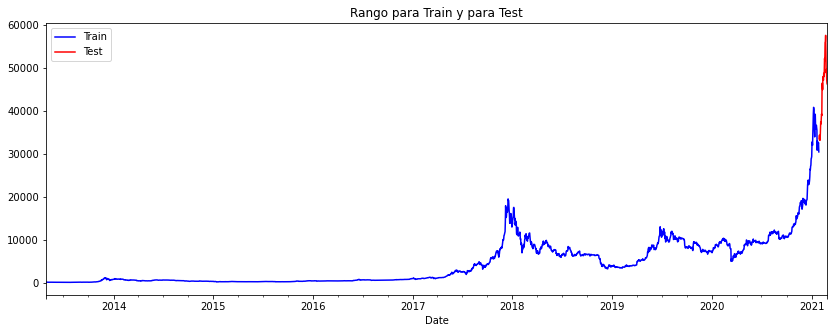

In [26]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
df_train.plot(kind='line', x='Date', y='Close', color='blue', label='Train', ax = ax)
df_test.plot(kind='line', x='Date', y='Close', color='red', label='Test', ax = ax)
ax.legend(loc= "upper left")
plt.title('Rango para Train y para Test')
plt.show()

#### Ploteo del Target en escala logarítmica:

In [12]:
df_train['log_value'] = np.log(df_train['Close'])
df_test['log_value'] = np.log(df_test['Close'])

In [13]:
def plot_df(df, x, y, title = "/", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi),
    plt.plot(x, y, color='tab:red'),
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel),
    plt.show()

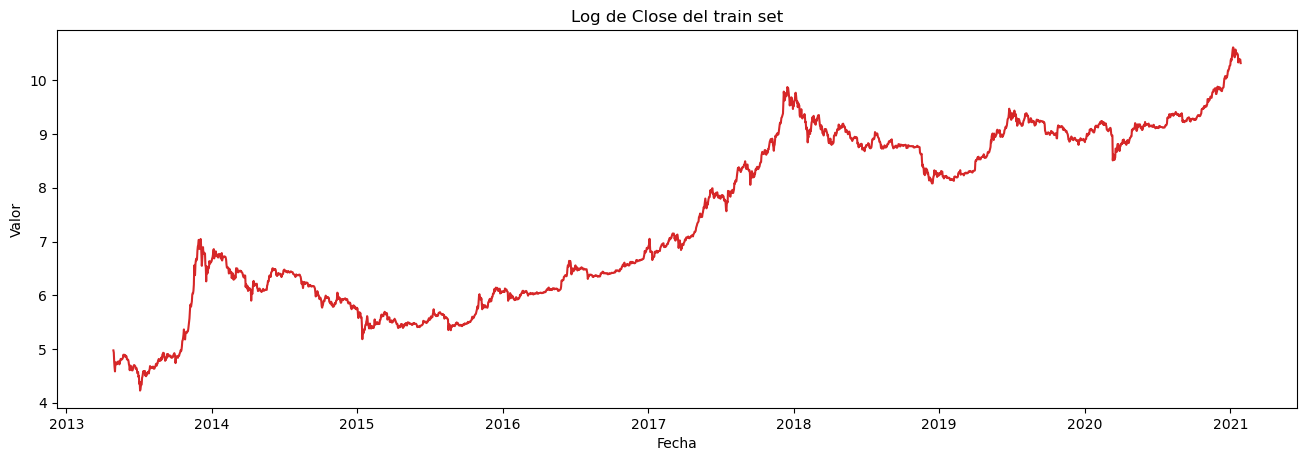

In [14]:
plot_df(df_train, x=df_train.Date, y=df_train['log_value'],\
    title='Log de Close del train set')

#### Entrenaiento del modelo para analizar el Summary:

In [15]:
model_log = smf.ols('log_value ~ timeIndex',\
                          data = df_train).fit()

In [16]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 1.434e+04
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:51:31   Log-Likelihood:                -2770.3
No. Observations:                2831   AIC:                             5545.
Df Residuals:                    2829   BIC:                             5556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8828      0.024    201.754      0.000       4.835       4.930
timeIndex      0.0018   1.48e-05    119.736      0.000       0.002       0.002
==============================================================================
Omnibus:                      222.150   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.407
Skew:                           0.746   Prob(JB):                     1.91e-59
Kurtosis:                       2.747   Cond. No.                     3.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 2) Modelos

Se utilizará una plétora de herramientas y recursos para analizar las series de tiempo y sus implicancias. En cada paso se irá visualizando los resultados y almacenando su información para, al final de la notebook, compararlos

## a) Mean

#### Se aplica el modelo de media constante a train y test:

In [17]:
# Se calcula el promedio:
model_mean_pred = df_train['Close'].mean()

# La predicción es fija y es la misma para el set de testeo y de entrenamiento:
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

#### Ploteo de las predicciones vs las series reales, en train y test:

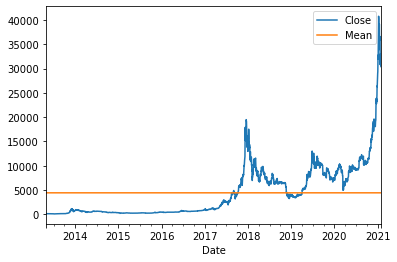

In [18]:
df_train.plot(kind="line", y = ["Close", "Mean"]);

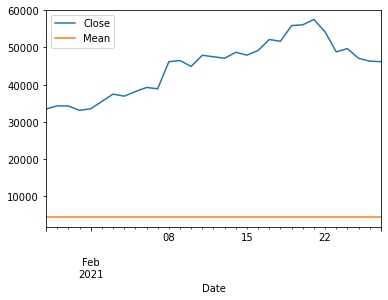

In [19]:
df_test.plot(kind="line", y = ["Close", "Mean"]);

#### Se define una función para calcular el RMSE:

In [20]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

#### Se define una función para calcular el MAPE:

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [22]:
# Aplicación del MAPE en Mean
model_MAPE = mean_absolute_percentage_error(df_test.Close , df_test.Mean)
print("El MAPE es ", model_MAPE)

El MAPE es  89.84516144847098


In [23]:
# Aplicación del RMSE en Mean
print("El RMSE es ", RMSE(df_test.Mean, df_test.Close))

El RMSE es  40968.433969121186


#### Se guardan los resultados en un DataFrame:

El mismo será reutilizado para almacenar los resultados de los distintos modelos a utilizar

In [24]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE","MAPE"])
df_Results.loc[0, "Model"] = "Mean"
df_Results.loc[0, "RMSE"] = RMSE(df_test.Mean, df_test.Close)
df_Results.loc[0, "MAPE"] = model_MAPE
df_Results.head()

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452


## b) RandomWalk

Se crea el shift de target en train:

In [25]:
df_train["CloseShift"] = df_train.Close.shift()
# La primera observación va a quedar en nan, por lo que se reemplaza por el valor siguente:
df_train["CloseShift"].fillna(method='bfill', inplace=True)
df_train.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,log_value,Mean,CloseShift
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29,1,Bitcoin,BTC,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,0,0,0,0,0,0,0,4.973556,4415.425613,144.539993
2013-04-30,2,Bitcoin,BTC,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,0,0,0,0,0,0,0,4.934474,4415.425613,144.539993
2013-05-01,3,Bitcoin,BTC,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,0,0,0,0,0,0,0,4.762088,4415.425613,139.000000
2013-05-02,4,Bitcoin,BTC,2013-05-02,125.599999,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,0,0,0,0,0,0,0,4.655958,4415.425613,116.989998
2013-05-03,5,Bitcoin,BTC,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,0,0,0,0,0,0,0,4.582413,4415.425613,105.209999


Se crea el shift de target en test:

In [26]:
df_test["CloseShift"] = df_test.Close.shift()
# Se puede reemplazar el primer nan con el último valor del set de entrenamiento:
df_test.iloc[0,26] = df_train.iloc[-1,0]
df_test.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,log_value,Mean,CloseShift
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-28,2832,Bitcoin,BTC,2021-01-28,33858.31099,30023.20683,30441.04182,33466.09636,7.651716e+10,6.229100e+11,...,0,0,0,0,0,0,0,10.418288,4415.425613,2831.00000
2021-01-29,2833,Bitcoin,BTC,2021-01-29,38406.26096,32064.81419,34318.67169,34316.38765,1.178950e+11,6.387690e+11,...,0,0,0,0,0,0,0,10.443378,4415.425613,33466.09636
2021-01-30,2834,Bitcoin,BTC,2021-01-30,34834.70830,32940.18691,34295.93504,34269.52154,6.514183e+10,6.379250e+11,...,0,0,0,0,0,0,0,10.442012,4415.425613,34316.38765
2021-01-31,2835,Bitcoin,BTC,2021-01-31,34288.33148,32270.17602,34270.87759,33114.35775,5.275454e+10,6.164530e+11,...,0,0,0,0,0,0,0,10.407722,4415.425613,34269.52154
2021-02-01,2836,Bitcoin,BTC,2021-02-01,34638.21349,32384.22811,33114.57724,33537.17682,6.140040e+10,6.243490e+11,...,0,0,0,0,0,0,0,10.420410,4415.425613,33114.35775


Lag de un período:

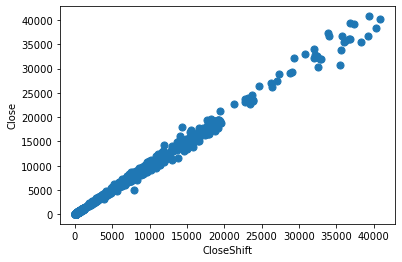

In [27]:
df_train.plot(kind= "scatter", y = "Close", x = "CloseShift", s = 50);

Diferencias entre Target y el lag:

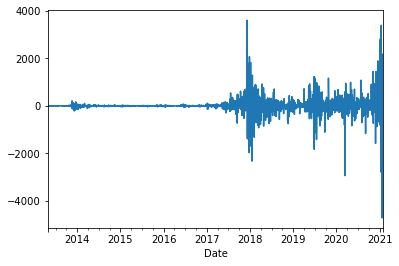

In [28]:
df_train["Closediff"] = df_train.Close - df_train.CloseShift
df_train.Closediff.plot();

#### Ploteo de las predicciones vs las series reales, en train y test:

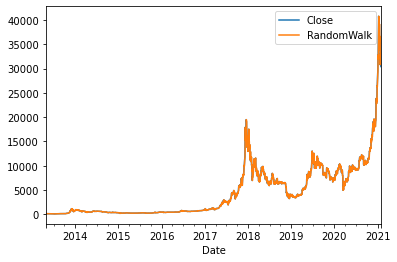

In [29]:
df_train["RandomWalk"] = df_train.CloseShift
df_train.plot(kind="line", y = ["Close", "RandomWalk"]);

In [30]:
df_test["RandomWalk"] = pd.Series(df_train["Close"][-1], index=df_test.index)

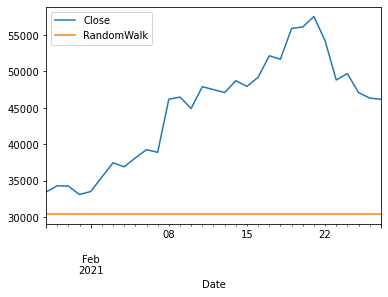

In [31]:
df_test.plot(kind="line", y = ["Close", "RandomWalk"]);

#### Se calcula el MAPE + RMSE y se almacena

In [32]:
model_MAPE = mean_absolute_percentage_error (df_test.Close , df_test.RandomWalk)

In [33]:
df_Results.loc[1, "Model"] = "Random Walk"
df_Results.loc[1, "RMSE"] = RMSE(df_test.RandomWalk, df_test.Close)
df_Results.loc[1, "MAPE"] = model_MAPE
df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096


In [34]:
# Para un resumen, se utiliza el Summary:
model_linear = smf.ols('Close ~ timeIndex', data = df_train).fit()

In [35]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     3945.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:51:32   Log-Likelihood:                -27197.
No. Observations:                2831   AIC:                         5.440e+04
Df Residuals:                    2829   BIC:                         5.441e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2939.2871    135.218    -21.737      0.000   -3204.423   -2674.151
timeIndex      5.1977      0.083     62.811      0.000       5.035       5.360
==============================================================================
Omnibus:                     2081.927   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43129.622
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      20.943   Cond. No.                     3.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## c) Linear Trend

#### Se crea una columna en train con el predict:

In [36]:
df_train["LinearTrend"] = model_linear.predict(df_train.timeIndex)

#### Ploteo de las predicciones vs las series reales, en train y test:

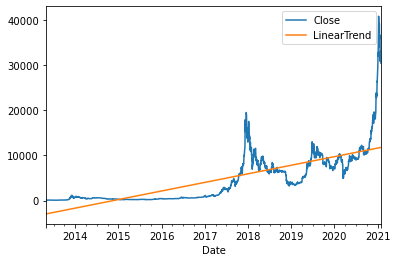

In [37]:
df_train.plot(kind = "line", y = ["Close","LinearTrend"]);

#### Se repete en Test:

In [38]:
df_test["LinearTrend"] = model_linear.predict(df_test.timeIndex)

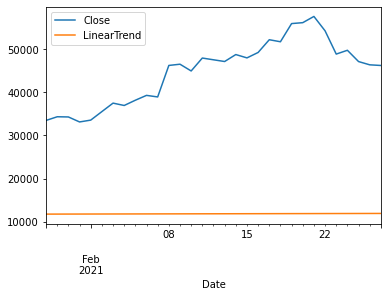

In [39]:
df_test.plot(kind = "line", y = ["Close","LinearTrend"]);

#### Se calcula el MAPE + RMSE y se almacena

In [40]:
model_MAPE = mean_absolute_percentage_error (df_test.Close , df_test.LinearTrend)

In [41]:
df_Results.loc[2, "Model"] = "LinearTrend"
df_Results.loc[2, "RMSE"] = RMSE(df_test.LinearTrend, df_test.Close)
df_Results.loc[2, "MAPE"] = model_MAPE
df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755


## d) Transf Log

In [42]:
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [43]:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

#### Ploteo de las predicciones vs las series reales, en train y test:

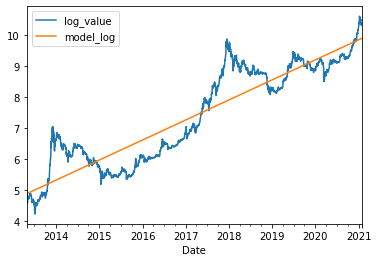

In [44]:
df_train.plot(kind = "line", x = "Date", y = ['log_value', 'model_log']);

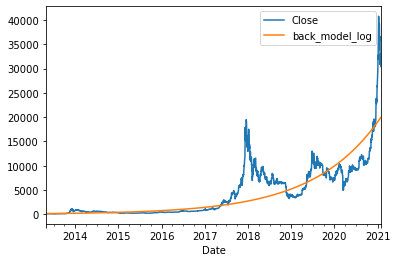

In [45]:
df_train.plot(kind = "line", x = "Date", y = ['Close', 'back_model_log']);

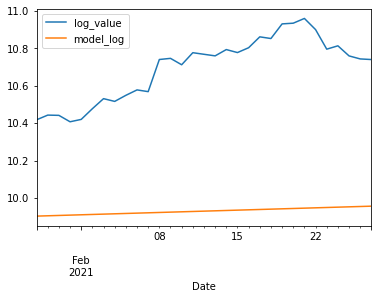

In [46]:
df_test.plot(kind = "line", x = "Date", y = ['log_value', 'model_log']);

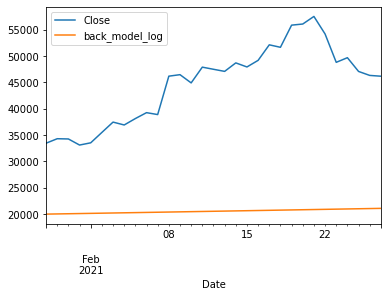

In [47]:
df_test.plot(kind = "line", x = "Date", y = ['Close', 'back_model_log']);

#### Se calcula el MAPE + RMSE y se almacena

In [48]:
model_MAPE = mean_absolute_percentage_error (df_test.Close , df_test.back_model_log)

In [49]:
df_Results.loc[3, "Model"] = "Transf Log"
df_Results.loc[3, "RMSE"] = RMSE(df_test['back_model_log'], df_test['Close'])
df_Results.loc[3, "MAPE"] = model_MAPE
df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755
3,Transf Log,25190.7,52.8786


## e) Transf Log + Est

In [50]:
model_log_est = smf.ols('log_value ~ timeIndex + Month_2 + Month_3 + Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_11 + Month_12',\
                          data = df_train).fit()


In [51]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex",\
                                              "Month_2", "Month_3", "Month_4", "Month_5",\
                                               "Month_6","Month_7", "Month_8", "Month_9","Month_10","Month_11","Month_12"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex",\
                                               "Month_2", "Month_3", "Month_4", "Month_5",\
                                               "Month_6","Month_7", "Month_8", "Month_9","Month_10","Month_11","Month_12"]])

In [52]:
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

#### Ploteo de las predicciones vs las series reales, en train y test:

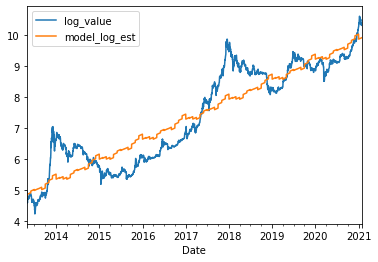

In [53]:
df_train.plot(kind = "line", x = "Date", y = ['log_value', 'model_log_est']);

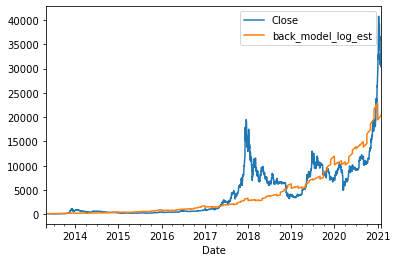

In [54]:
df_train.plot(kind = "line", x = "Date", y = ['Close', 'back_model_log_est']);

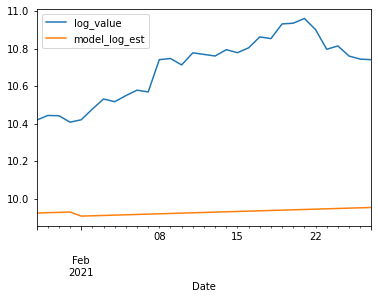

In [55]:
df_test.plot(kind = "line", x = "Date", y = ['log_value', 'model_log_est']);

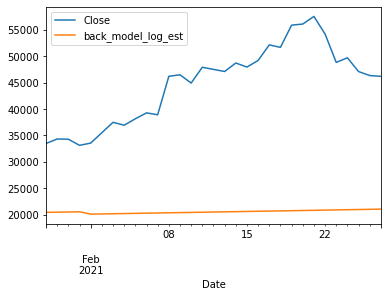

In [56]:
df_test.plot(kind = "line", x = "Date", y = ['Close', 'back_model_log_est']);

#### Se calcula el MAPE + RMSE y se almacena

In [57]:
model_MAPE = mean_absolute_percentage_error (df_test.Close , df_test.back_model_log_est)

In [58]:
df_Results.loc[4, "Model"] = "Transf Log + est"
df_Results.loc[4, "RMSE"] = RMSE(df_test['back_model_log_est'], df_test['Close'])
df_Results.loc[4, "MAPE"] = model_MAPE
df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755
3,Transf Log,25190.7,52.8786
4,Transf Log + est,25220,52.8444


## f) Simple Smoothing

#### Fiteo del modelo:

In [59]:
model_exp_smoothing = SimpleExpSmoothing(df_train.Close).fit(smoothing_level=0.3, optimized=False)

#### Ploteo de las predicciones vs las series reales, en train y test:

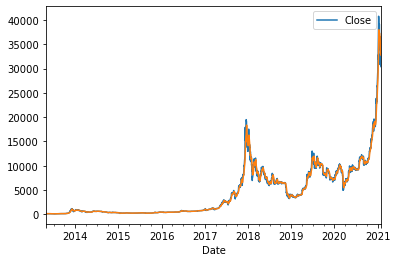

In [60]:
df_train.plot(kind = "line", y = "Close")
model_exp_smoothing.fittedvalues.plot();

In [61]:
# Se define cantidad de splits:
tscv = TimeSeriesSplit(n_splits=5)

In [62]:
for train_index, val_index in tscv.split(df_train):
    print("TRAIN:", train_index, "VAL:", val_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

Creación de una función para aplicar Cross Validation

In [63]:
def timeseriesCVscore_exp_smoot(alpha, series):
    """
        Devuelve errores en CV  
        
        slen - longitud de la sesión para modelo Holt-Winters
    """
    # Se crea un array de errores:
    errors = []
    values = series.values
    
    # Se instancia el objeto que realiza el tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # Se aplica cross validation:
    for train, test in tscv.split(values):
    
        model = SimpleExpSmoothing(values[train]).fit(smoothing_level = alpha, optimized=False)     
        predictions = model.forecast(len(test))
        actual = values[test]
    
        error = mean_squared_error(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

Aplicación de la función

In [64]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.7]
errors = []

for alpha in alphas:
    error = timeseriesCVscore_exp_smoot(alpha, df_train.Close)
    errors.append(error)

print('Alpha óptimo:', alphas[np.argmin(errors)])

Alpha óptimo: 0.1


In [65]:
model_exp_smoothing = SimpleExpSmoothing(df_train.Close).fit(smoothing_level=alphas[np.argmin(errors)], optimized=False)

In [66]:
df_test["Simple_Smoothing"] = model_exp_smoothing.forecast(len(df_test))
df_test.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,log_value,Mean,CloseShift,RandomWalk,LinearTrend,model_log,back_model_log,model_log_est,back_model_log_est,Simple_Smoothing
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-28,2832,Bitcoin,BTC,2021-01-28,33858.31099,30023.20683,30441.04182,33466.09636,7.651716e+10,6.229100e+11,...,10.418288,4415.425613,2831.00000,30432.54708,11775.336020,9.903266,19995.562080,9.923727,20408.903014,33347.84119
2021-01-29,2833,Bitcoin,BTC,2021-01-29,38406.26096,32064.81419,34318.67169,34316.38765,1.178950e+11,6.387690e+11,...,10.443378,4415.425613,33466.09636,30432.54708,11780.533697,9.905039,20031.053582,9.925496,20445.051836,33347.84119
2021-01-30,2834,Bitcoin,BTC,2021-01-30,34834.70830,32940.18691,34295.93504,34269.52154,6.514183e+10,6.379250e+11,...,10.442012,4415.425613,34316.38765,30432.54708,11785.731374,9.906812,20066.608080,9.927266,20481.264685,33347.84119
2021-01-31,2835,Bitcoin,BTC,2021-01-31,34288.33148,32270.17602,34270.87759,33114.35775,5.275454e+10,6.164530e+11,...,10.407722,4415.425613,34269.52154,30432.54708,11790.929051,9.908586,20102.225685,9.929035,20517.541675,33347.84119
2021-02-01,2836,Bitcoin,BTC,2021-02-01,34638.21349,32384.22811,33114.57724,33537.17682,6.140040e+10,6.243490e+11,...,10.420410,4415.425613,33114.35775,30432.54708,11796.126727,9.910359,20137.906512,9.907257,20075.524059,33347.84119


#### Se calcula el MAPE + RMSE y se almacena

In [67]:
model_MAPE = mean_absolute_percentage_error(df_test.Close , df_test.Simple_Smoothing)

In [68]:
# Calculamos el RMSE y almacenamos los resultados
df_Results.loc[5, "Model"] = "Simple Smoothing"
df_Results.loc[5, "RMSE"] = RMSE(df_test["Simple_Smoothing"], df_test.Close)
df_Results.loc[5, "MAPE"] = model_MAPE

df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755
3,Transf Log,25190.7,52.8786
4,Transf Log + est,25220,52.8444
5,Simple Smoothing,13517.5,23.3503


#### Ploteo de las predicciones vs las series reales, en train y test:

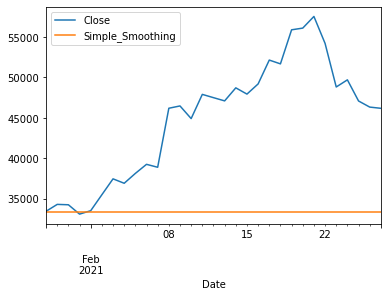

In [69]:
df_test.plot(kind="line", y = ["Close", "Simple_Smoothing"]);

## g) Dickey Fuller + Autocorrelación

#### Se prueba si los residuos son estacionarios

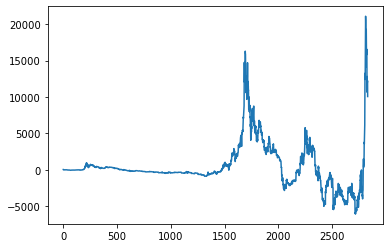

In [70]:
residuo = df_train['Close'] - df_train['back_model_log_est']
plt.plot(df_train.timeIndex, residuo, '-');

#### Aplicación de Dickey Fuller al residuo: 

In [71]:
result = adfuller(residuo)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.831115
p-value: 0.053965
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


No se puede rechazar la H0 con un nivel de significación del 5%.

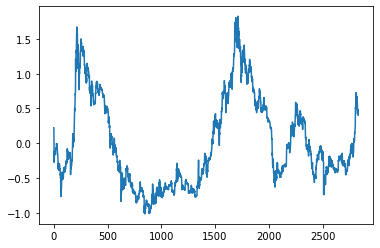

In [72]:
# Se prueba ahora con los residuos antes de realizar back transform:
res_log_est = df_train['log_value'] - df_train['model_log_est']
plt.plot(df_train.timeIndex, res_log_est, '-');

#### Segundo testeo de la estacionalidad de los residuos:

In [73]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.176515
p-value: 0.214879
Valor crítico 1%: -3.43
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


Aún no se puede rechazar la H0, pero se continúa el análisis

In [74]:
# Cálculo del res_log con 20 rezagos:
lag_acf = acf(res_log_est, nlags = 20)
lag_acf

array([1.        , 0.9973684 , 0.99471906, 0.99215484, 0.98968734,
       0.98710619, 0.98434791, 0.98131918, 0.97840278, 0.97558444,
       0.97280571, 0.969828  , 0.96671826, 0.9635972 , 0.96047466,
       0.95735437, 0.95426951, 0.95116815, 0.94768699, 0.94429688,
       0.94100531])

#### Se almacena la serie ACF y se plotea:

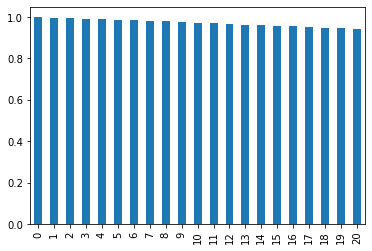

In [75]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

#### Se repiten los pasos anteriores pero con PACF:

In [76]:
lag_pacf = pacf(res_log_est, nlags=20, method='ols');

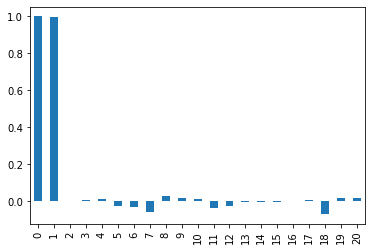

In [77]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

Se puede concluir de este análisis que la correlación indirecta es alta, pero la parcial que considera solo influencia directa de cada período es absoluta en tan solo un mes antes del momento a analizar: esto habla de la alta volatilidad del caso a analizar, ya que se deduce de la herramienta y los datos que es de poca utilidad para la predicción de valores en las criptomonedas la utilización de información de más de un mes atrás

#### Se crea una función para plotear una serie con información sobre los ACF y PACF y su estacionalidad:

In [78]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # Se definen ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # Se obtiene el p-value con H0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # Plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # Plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

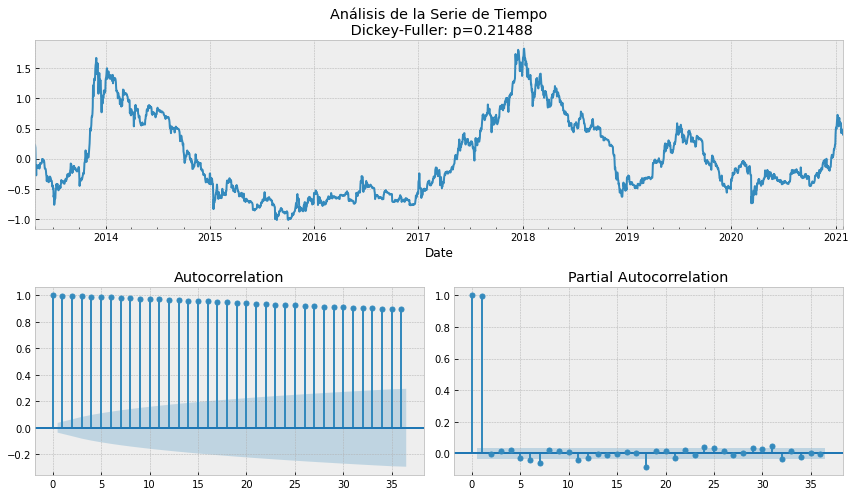

In [79]:
# Aplicación de la función con la serie res_log:
tsplot(res_log_est, lags=36)

## h) ARIMA

#### Se aplica el auto_arima sobre res_log_est

In [82]:
stepwise_fit = auto_arima(res_log_est, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9444.242, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9452.140, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9450.140, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9450.140, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9454.135, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9448.140, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.410 seconds


#### Como se obtuvo mejores resultados con p=2 y q=1, s aplica:

In [83]:
model_ARIMA = ARIMA(res_log_est, order=(2,0,1))

# Estimación del modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Date
2013-04-29    0.047615
2013-04-30    0.221465
2013-05-01    0.180451
2013-05-02   -0.095721
2013-05-03   -0.204006
Freq: D, dtype: float64

#### Se observa el summary:

In [84]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 2831
Model:                     ARMA(2, 1)   Log Likelihood                4731.924
Method:                       css-mle   S.D. of innovations              0.045
Date:                Thu, 15 Apr 2021   AIC                          -9453.849
Time:                        01:52:33   BIC                          -9424.107
Sample:                    04-29-2013   HQIC                         -9443.119
                         - 01-27-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0476      0.169      0.281      0.778      -0.284       0.379
ar.L1.y        1.9921      0.000   8066.025      0.000       1.992       1.993
ar.L2.y       -0.9921      0.000  -4038.721      0.0

#### Ploteo de resultados:

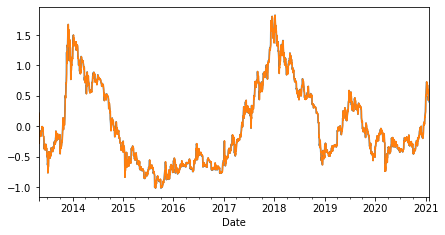

In [85]:
plt.figure(figsize=(7,3.5))
res_log_est.plot()
results_ARIMA.fittedvalues.plot();

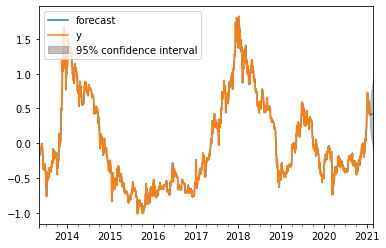

In [86]:
results_ARIMA.plot_predict(end=len(df['Close']));

#### Análisis de los residuos del modelo ARIMA:

In [87]:
res_ARIMA =  results_ARIMA.fittedvalues - res_log_est

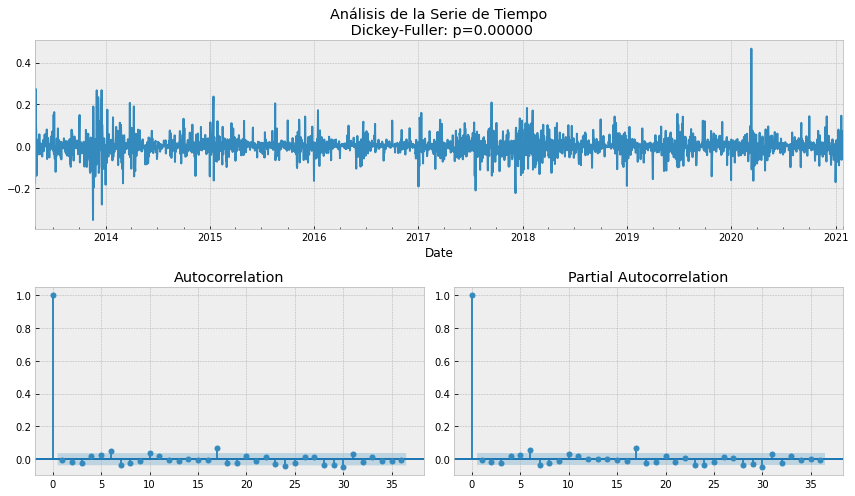

In [88]:
tsplot(res_ARIMA, lags=36)

#### Aplicación del método Forecast:

In [89]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Close']), alpha=0.05)

In [90]:
# Se crea una variable en train y test y se plotea los resultados:

df_train['log_model_ARIMA'] = df_train['model_log_est'] + results_ARIMA.fittedvalues

df_test['log_model_ARIMA'] = df_test['model_log_est'] + predictions_ARIMA

#### Ploteo de las predicciones vs las series reales, en train y test:

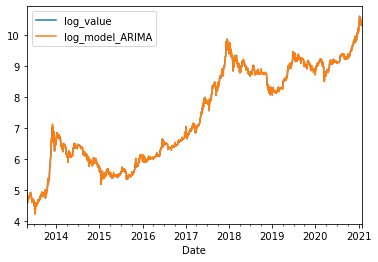

In [91]:
df_train.plot(kind = "line", y = ['log_value', 'log_model_ARIMA']);

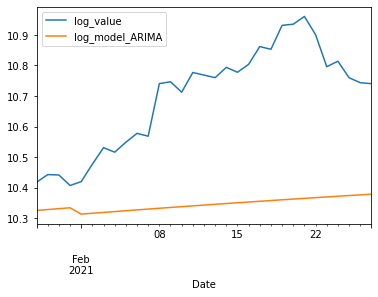

In [92]:
df_test.plot(kind = "line", y = ['log_value', 'log_model_ARIMA']);

In [93]:
# Se crea una variable en train y test con back transformation del modelo log y se plotea resultados:

df_train['back_log_model_ARIMA'] = np.exp(df_train['log_model_ARIMA'])

df_test['back_log_model_ARIMA'] = np.exp(df_test['log_model_ARIMA'])

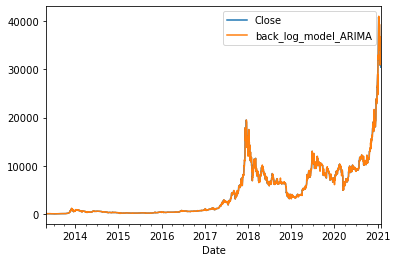

In [94]:
df_train.plot(kind = "line", y = ['Close', 'back_log_model_ARIMA']);

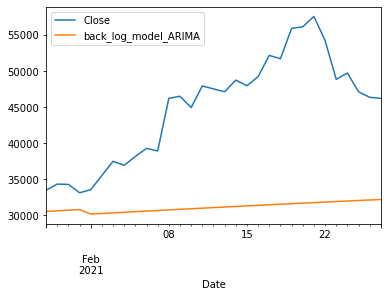

In [95]:
df_test.plot(kind = "line", y = ['Close', 'back_log_model_ARIMA']);

#### Se calcula el MAPE + RMSE y se almacena

In [96]:
model_MAPE = mean_absolute_percentage_error (df_test.Close , df_test.back_log_model_ARIMA)

In [97]:
df_Results.loc[6, "Model"] = "Log Model + est + ARIMA"
df_Results.loc[6, "RMSE"] = RMSE(df_test['back_log_model_ARIMA'], df_test['Close'])
df_Results.loc[6, "MAPE"] = model_MAPE

df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755
3,Transf Log,25190.7,52.8786
4,Transf Log + est,25220,52.8444
5,Simple Smoothing,13517.5,23.3503
6,Log Model + est + ARIMA,15220.8,28.5881


# 3) Comparación de resultados

#### Análisis de RMSE y MAPE en cuadro

Como el Prophet se aplica en la siguiente notebook, se insertan los resultados manualmente a continuación:

In [98]:
df_Results.loc[7, "Model"] = "Prophet"
df_Results.loc[7, "RMSE"] = "6997.16"
df_Results.loc[7, "MAPE"] = "15.54"

df_Results

,Model,RMSE,MAPE
0,Mean,40968.4,89.8452
1,Random Walk,16049.4,30.0096
2,LinearTrend,33666.9,72.755
3,Transf Log,25190.7,52.8786
4,Transf Log + est,25220,52.8444
5,Simple Smoothing,13517.5,23.3503
6,Log Model + est + ARIMA,15220.8,28.5881
7,Prophet,6997.16,15.54


#### Análisis de RMSE y MAPE visualizado

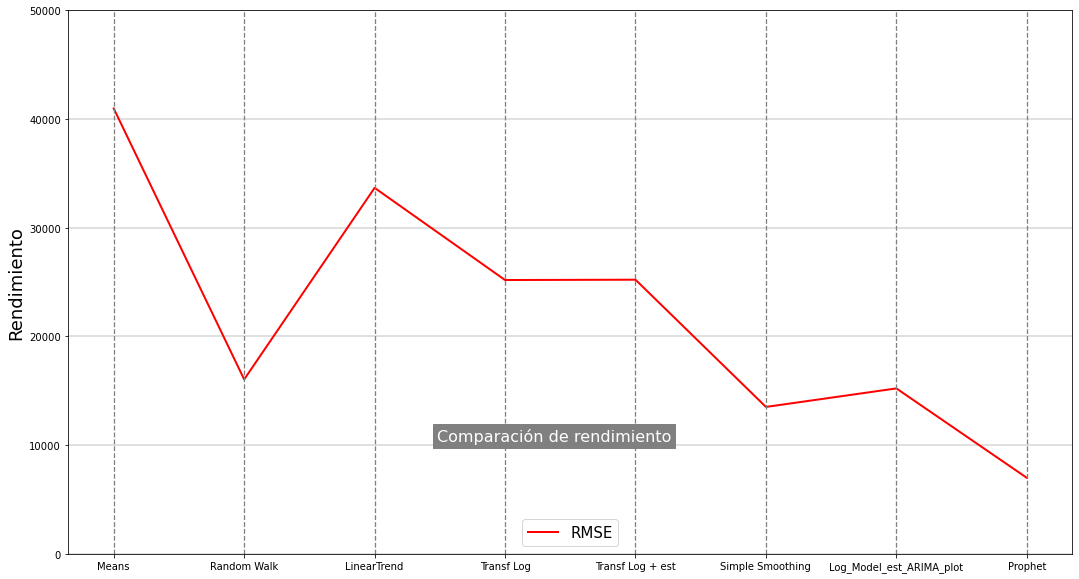

In [99]:
plt.figure(figsize=(18, 10)).suptitle('Comparación de rendimiento', y=0.3, fontsize = 16, color='white', backgroundcolor='gray')
plt.plot(df_Results.RMSE, color='red', linewidth=2, label = "RMSE")


plt.ylabel('Rendimiento', fontsize=18)
plt.legend(fontsize = 15)

axes= plt.gca()
ymin= 0
ymax= 50000
axes.set_ylim([ymin, ymax])

plt.axvline(x='Means', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Random Walk',color="grey", linestyle="--", lw=1.3)
plt.axvline(x='LinearTrend', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Transf Log' , color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Transf Log + est', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Simple Smoothing', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Log_Model_est_ARIMA_plot', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Prophet', color="grey", linestyle="--", lw=1.3)

plt.grid(which='major', axis='y', color='black', lw=0.4, alpha=0.6)
plt.show()

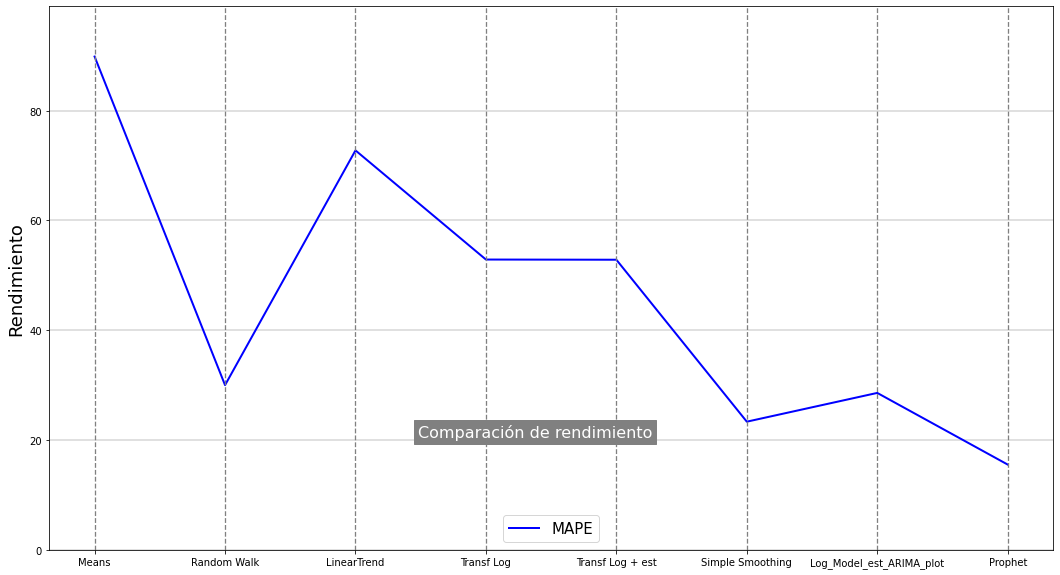

In [100]:
plt.figure(figsize=(18, 10)).suptitle('Comparación de rendimiento', y=0.3, fontsize = 16, color='white', backgroundcolor='gray')
plt.plot(df_Results.MAPE, color='b', linewidth=2, label = "MAPE")


plt.ylabel('Rendimiento', fontsize=18)
plt.legend(fontsize = 15)

axes= plt.gca()
ymin= 0
ymax= 99
axes.set_ylim([ymin, ymax])

plt.axvline(x='Means', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Random Walk',color="grey", linestyle="--", lw=1.3)
plt.axvline(x='LinearTrend', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Transf Log' , color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Transf Log + est', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Simple Smoothing', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Log_Model_est_ARIMA_plot', color="grey", linestyle="--", lw=1.3)
plt.axvline(x='Prophet', color="grey", linestyle="--", lw=1.3)

plt.grid(which='major', axis='y', color='black', lw=0.4, alpha=0.6)
plt.show()

En la 3ra y última notebook se prueba una herramienta no vista en el curso. Se separó para ser planteada como un anexo, debido a nuestra incertidumbre de sus resultados ya que no fue trabajada en clase.